# Preface

Алгоритмы **квантовых вычислений** изучены далеко не так хорошо как классические алгоритмы. Но они демонстрируют высокий потенциал, и программнные инструменты для их реализации уже доступны разработчикам. Чтобы познакомиться с данными инструментами, а также оценить эффективность решений предоставляемых квантовыми вычислениями для сферы финтеха, мы реализуем несколько алгоритмов.

# QAOA vs ?

## Dataset - S&P 500 stock data

### Описание

[Данный датасет](https://www.kaggle.com/datasets/camnugent/sandp500/data) представляет собой данные за пять лет по рынку акций списка [S&P 500](https://stockanalysis.com/list/sp-500-stocks/).

### Содержание

Файл данных содержит следующие колонки:

- Date - in format: yy-mm-dd
- Open - price of the stock at market open (this is NYSE data so all in USD Billions)
- High - Highest price reached in the day
- Low Close - Lowest price reached in the day
- Volume - Number of shares traded
- Name - the stock's ticker name

### Предобработка

### Выбор пула стоков

Современные NISQ системы показывают приемлимые результаты для данной модели в пределе пула размером 20, поэтому мы ограничимся таким числом.
В целях исследования, разобъем исследуемые данные на три группы - по максимальному достигнутому значению цены акции (High) для каждой компании (Name). Выберем интервал 'до \\$30B', 'от \\$30B до \\$100B', и 'от \\$100B'. В первых двух интервалах выберем по пять компаний, в последнем десять.

In [589]:
import pandas as pd
pf_df = pd.read_csv('./datasets/all_stocks_5yr.csv')

In [590]:
pf_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  str    
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  str    
dtypes: float64(4), int64(1), str(2)
memory usage: 33.1 MB


In [591]:
pf_df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [592]:
pf_df.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


In [593]:
# Уберем из списка стоки с NA данными
pf_df.drop(pf_df.loc[pf_df['open'].isna(), 'Name'].isin(pf_df['Name']).index, inplace=True)
pf_df.drop(pf_df.loc[pf_df['high'].isna(), 'Name'].isin(pf_df['Name']).index, inplace=True)
pf_df.drop(pf_df.loc[pf_df['low'].isna(), 'Name'].isin(pf_df['Name']).index, inplace=True)

In [594]:
# Преобразование типов
pf_df = pf_df.convert_dtypes()

In [595]:
pf_df.info()

<class 'pandas.DataFrame'>
Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619029 non-null  string 
 1   open    619029 non-null  Float64
 2   high    619029 non-null  Float64
 3   low     619029 non-null  Float64
 4   close   619029 non-null  Float64
 5   volume  619029 non-null  Int64  
 6   Name    619029 non-null  string 
dtypes: Float64(4), Int64(1), string(2)
memory usage: 40.7 MB


In [596]:
pf_df['date'] = pd.to_datetime(pf_df['date'])
pf_df.info()

<class 'pandas.DataFrame'>
Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619029 non-null  datetime64[us]
 1   open    619029 non-null  Float64       
 2   high    619029 non-null  Float64       
 3   low     619029 non-null  Float64       
 4   close   619029 non-null  Float64       
 5   volume  619029 non-null  Int64         
 6   Name    619029 non-null  string        
dtypes: Float64(4), Int64(1), datetime64[us](1), string(1)
memory usage: 40.7 MB


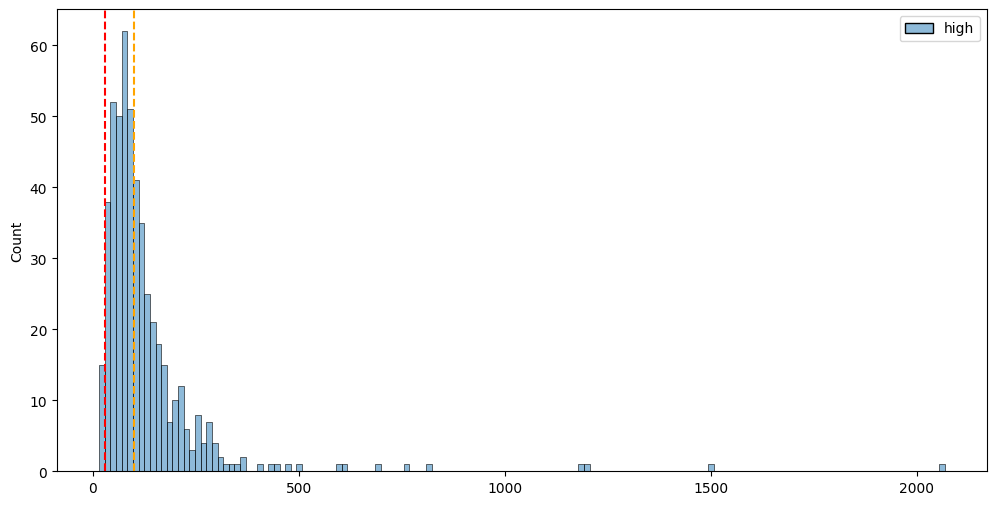

In [597]:
# Группы выбора на графике
import matplotlib.pyplot as plt
import seaborn as sns

high_max = pf_df[['high', 'Name']].groupby(['Name']).max()

_, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=high_max, bins=150, ax=ax)
plt.axvline(x=30, color='red', linestyle='--')
plt.axvline(x=100, color='orange', linestyle='--')
#TODO: use plotly or add plot without ouliers

In [598]:
pf_df1 = high_max[high_max['high'] <= 30].sample(5)
pf_df2 = high_max[high_max['high'].between(30, 100, inclusive='right')].sample(5)
pf_df3 = high_max[high_max['high'] > 100].sample(10)
#pf_df3
#pf_df[pf_df['high']high_max < 30]
#high_max[high_max['high'] < 30].sample(5)
pf_df[pf_df['Name'].isin(pf_df1.index)]['date'].value_counts()

date
2013-02-08    5
2013-02-11    5
2013-02-12    5
2013-02-13    5
2013-02-14    5
             ..
2018-02-01    5
2018-02-02    5
2018-02-05    5
2018-02-06    5
2018-02-07    5
Name: count, Length: 1259, dtype: int64

<Axes: ylabel='Frequency'>

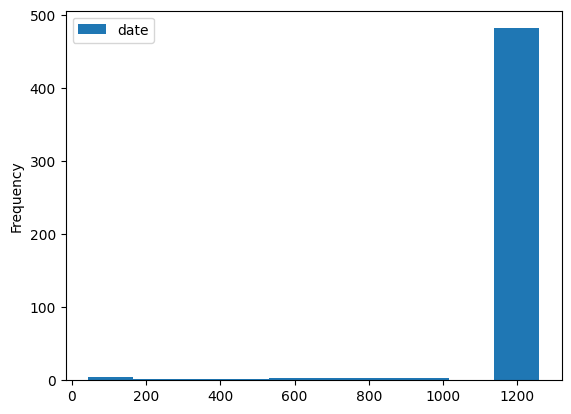

In [599]:
# Давайте узнаем как много организаций не имеют данных на полный период времени
pf_df[['date', 'Name']].groupby(['Name']).count().plot.hist()

In [600]:
# Попробуем использовать для исследования только полные данные.
dates = pf_df['date'].sort_values().unique()
pf_df = pf_df.groupby(['Name']).filter(lambda x: x['date'].count() == len(dates))
high_max = pf_df[['high', 'Name']].groupby(['Name']).max()
pf_df1 = high_max[high_max['high'] <= 30].sample(2, random_state=1)
pf_df2 = high_max[high_max['high'].between(30, 100, inclusive='right')].sample(2, random_state=1)
pf_df3 = high_max[high_max['high'] > 100].sample(6, random_state=1)
pf20_df = pf_df[pf_df['Name'].isin(pf_df1.index)]
pf20_df['class'] = 'C'
pf20_df = pd.concat([pf20_df, pf_df[pf_df['Name'].isin(pf_df2.index)]], ignore_index=True).fillna('B')
pf20_df = pd.concat([pf20_df, pf_df[pf_df['Name'].isin(pf_df3.index)]], ignore_index=True).fillna('A')

Text(0.5, 0.925, 'Closing prices, $B')

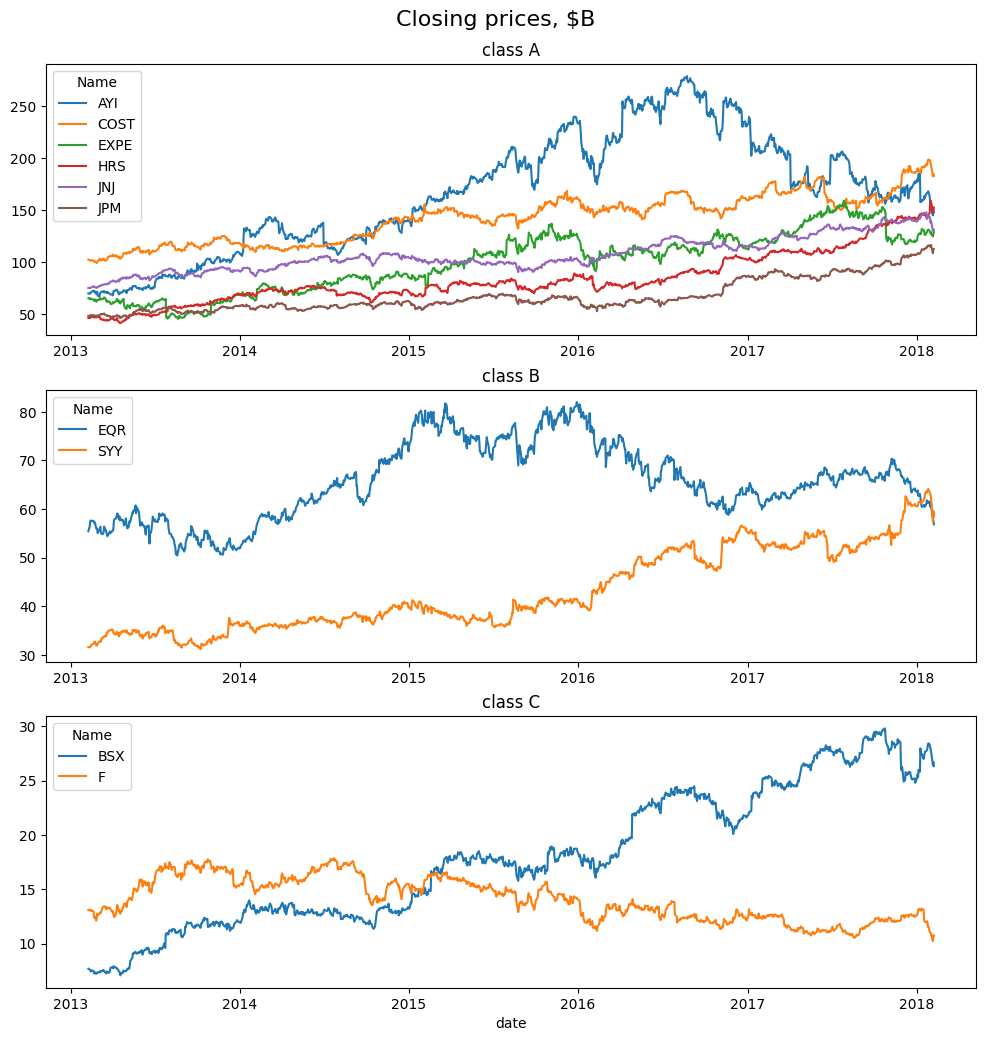

In [601]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
sns.lineplot(data=pf20_df[pf20_df['class'] == 'A'], x='date', y='close', hue='Name', ax=ax[0]).set(xlabel=None, ylabel=None, title='class A')
sns.lineplot(data=pf20_df[pf20_df['class'] == 'B'], x='date', y='close', hue='Name', ax=ax[1]).set(xlabel=None, ylabel=None, title='class B')
sns.lineplot(data=pf20_df[pf20_df['class'] == 'C'], x='date', y='close', hue='Name', ax=ax[2]).set(ylabel=None, title='class C')
fig.suptitle('Closing prices, $B', fontsize=16, y=0.925)
#g = sns.FacetGrid(pf20_df.sort_values('class'), row='class', aspect=4.)
#g.map(sns.lineplot, 'date', 'high', 'Name')
#g.add_legend()

In [602]:
#date80 = dates[int(0.8*len(dates))]
date_test  = max(dates) - pd.Timedelta(365, 'D')
pf20train_df = pf20_df[pf20_df['date'] <= date_test]
pf20test_df = pf20_df[pf20_df['date'] > date_test]
len(pf20train_df) + len(pf20test_df) == len(pf20_df)

True

In [603]:
pf20train_df = pf20train_df[['date', 'close', 'Name']].pivot(index='date', columns='Name', values='close').sort_values('date')
pf20test_df = pf20test_df[['date', 'close', 'Name']].pivot(index='date', columns='Name', values='close').sort_values('date')

In [604]:
pf20train_df
pf20_df['date'].value_counts()

date
2013-02-08    10
2013-02-11    10
2013-02-12    10
2013-02-13    10
2013-02-14    10
              ..
2018-02-01    10
2018-02-02    10
2018-02-05    10
2018-02-06    10
2018-02-07    10
Name: count, Length: 1259, dtype: int64

In [605]:
pd.Timestamp('2018-02-07') - pd.Timestamp('2013-02-08')

Timedelta('1825 days 00:00:00')

In [606]:
pf20_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 12590 entries, 0 to 12589
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    12590 non-null  datetime64[us]
 1   open    12590 non-null  Float64       
 2   high    12590 non-null  Float64       
 3   low     12590 non-null  Float64       
 4   close   12590 non-null  Float64       
 5   volume  12590 non-null  Int64         
 6   Name    12590 non-null  string        
 7   class   12590 non-null  str           
dtypes: Float64(4), Int64(1), datetime64[us](1), str(1), string(1)
memory usage: 848.5 KB


In [607]:
# Вычислим дневную доходность
pf20train_df = pf20train_df.diff() / pf20train_df.shift(1)#.div(pf20train_df.index.diff().days.to_series().to_list(), axis='index') / pf20train_df.shift(1)
pf20test_df = pf20test_df.diff() / pf20test_df.shift(1)#.div(pf20test_df.index.diff().days.to_series().to_list(), axis='index') / pf20test_df.shift(1)
#pf20train_df = pf20train_df.diff() / (pf20train_df.mul(pf20train_df.index.diff().days.to_series().to_list(), axis='index') - pf20train_df.diff())
#pf20test_df = pf20test_df.diff() / (pf20test_df.mul(pf20test_df.index.diff().days.to_series().to_list(), axis='index') - pf20test_df.diff())

In [608]:
pf20train_df = pf20train_df.iloc[1:]
pf20test_df = pf20test_df.iloc[1:]
pf20train_df.info(), pf20test_df.info()

<class 'pandas.DataFrame'>
DatetimeIndex: 1006 entries, 2013-02-11 to 2017-02-07
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AYI     1006 non-null   Float64
 1   BSX     1006 non-null   Float64
 2   COST    1006 non-null   Float64
 3   EQR     1006 non-null   Float64
 4   EXPE    1006 non-null   Float64
 5   F       1006 non-null   Float64
 6   HRS     1006 non-null   Float64
 7   JNJ     1006 non-null   Float64
 8   JPM     1006 non-null   Float64
 9   SYY     1006 non-null   Float64
dtypes: Float64(10)
memory usage: 96.3 KB
<class 'pandas.DataFrame'>
DatetimeIndex: 251 entries, 2017-02-09 to 2018-02-07
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AYI     251 non-null    Float64
 1   BSX     251 non-null    Float64
 2   COST    251 non-null    Float64
 3   EQR     251 non-null    Float64
 4   EXPE    251 non-null    Float64
 5   F       251 non-null   

(None, None)

<Axes: xlabel='Name', ylabel='annual daily returns'>

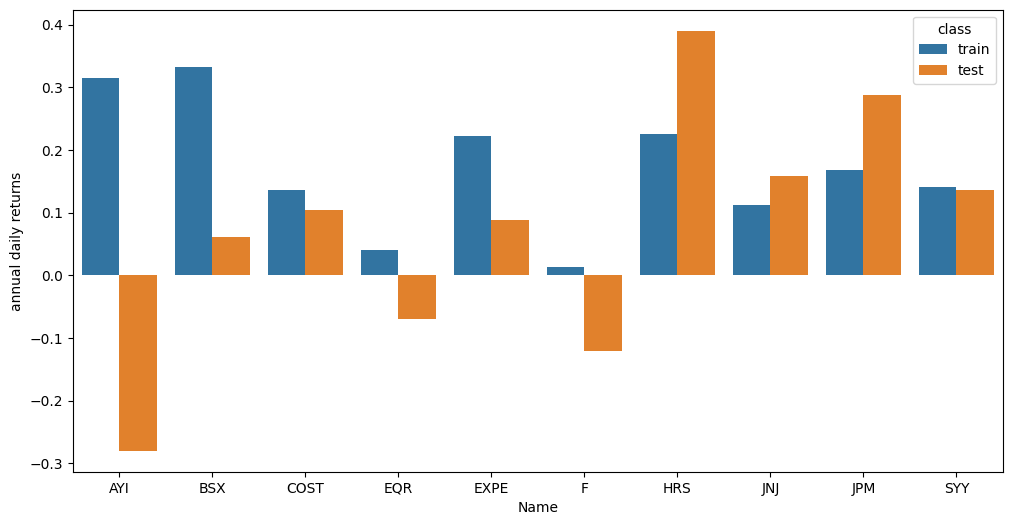

In [609]:
# Получаем годовые значения
pf20train_covann = pf20train_df.cov()*252
pf20test_covann = pf20test_df.cov()*252
pf20train_covann.max(axis=None)
pf20train_drann = pf20train_df.mean()*252
pf20test_drann = pf20test_df.mean()*252
pf20_drann = pf20train_drann.to_frame()
pf20_drann['class'] = 'train'
pf20_drann = pd.concat([pf20_drann, pf20test_drann]).fillna('test')
pf20_drann.columns = ['annual daily returns', 'class']
plt.figure(figsize=(12, 6))
sns.barplot(pf20_drann, x='Name', y='annual daily returns', hue='class')

Text(0.5, 0.95, 'Annualized covariance matrix for daily returns')

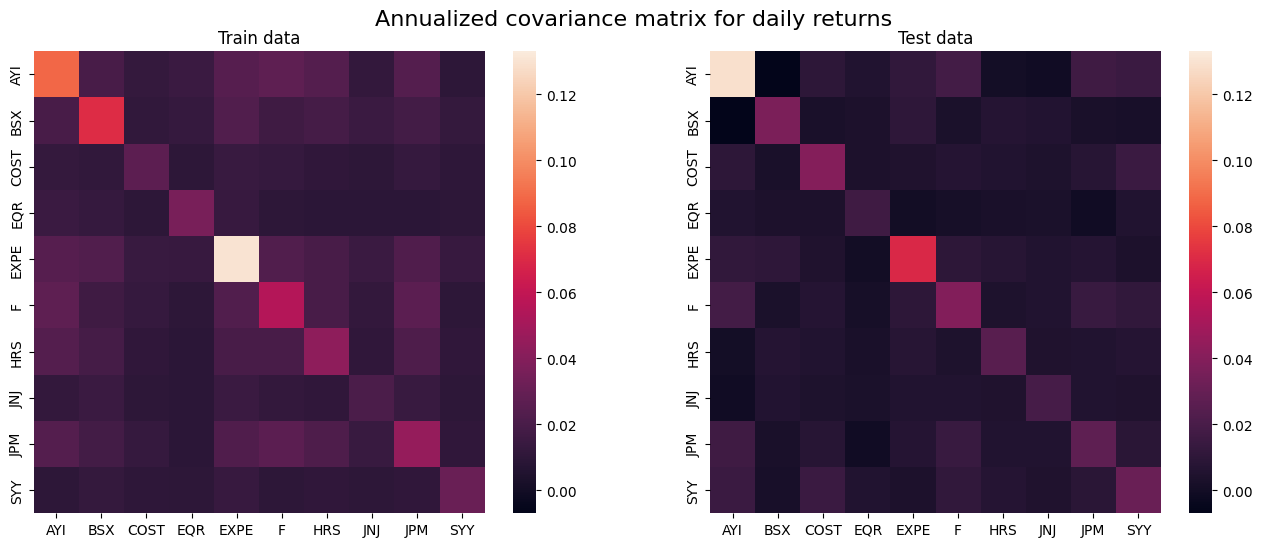

In [610]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
vmin = 0.975 * min(pf20train_covann.min(axis=None), pf20test_covann.min(axis=None))
vmax = 1.025 * max(pf20train_covann.max(axis=None), pf20test_covann.max(axis=None))
sns.heatmap(pf20train_covann, vmin=vmin, vmax=vmax, ax=ax[0]).set(xlabel=None, ylabel=None, title='Train data')
sns.heatmap(pf20test_covann, vmin=vmin, vmax=vmax, ax=ax[1]).set(xlabel=None, ylabel=None, title='Test data')
fig.suptitle('Annualized covariance matrix for daily returns', fontsize=16, y=0.95)

## Implementation

In [611]:
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import pennylane as qml
from pennylane import qaoa
import numpy as np
from scipy.optimize import minimize


def portfolio_optimisation_ex_qaoa(mu, sigma, budget, n_layers, n_iter, n_shots=4096, n_levels=2, simulator="lightning.qubit"):
    n_assets = len(mu)
    risk_factor = 0.5
    n_qubits = n_assets * n_levels
    dev = qml.device(simulator, wires=n_qubits)

    # Classical (exact) solution
    pf = PortfolioOptimization(mu, sigma, risk_factor, budget)
    qp = pf.to_quadratic_program()
    
    converter = QuadraticProgramToQubo()
    qubo = converter.convert(qp)
    penalty_value = converter.penalty
    print(penalty_value)
    
    exact_mes = NumPyMinimumEigensolver()
    optimizer = MinimumEigenOptimizer(exact_mes)
    result_classic = optimizer.solve(qp)
    
    # QAOA solution
    ## Portfolio to Ising problem
    def portfolio_to_ising_coeffs(mu, sigma, budget, penalty_value, risk_factor):
        
        h = np.zeros(n_qubits)
        
        for i in range(n_assets):
            qubit_start = i * n_levels
            # Binary encoding: w_i = sum(2^k * b_{i,k})
            for k in range(n_levels):
                h[qubit_start + k] -= mu[i] * (2**k)
        
        J = np.zeros((n_qubits, n_qubits))
        
        for i in range(n_assets):
            for j in range(i, n_assets):
                if i == j:
                    continue
                else:
                    coeff = sigma[i, j]
                    for k1 in range(n_levels):
                        for k2 in range(n_levels):
                            q1 = i * n_levels + k1
                            q2 = j * n_levels + k2
                            J[q1, q2] += coeff * (2**(k1 + k2))
                            J[q2, q1] += coeff * (2**(k1 + k2))

        J = risk_factor * J

        for i in range(n_assets):
            for j in range(n_assets):
                w_i_scale = sum(2**k for k in range(n_levels))
                w_j_scale = sum(2**k for k in range(n_levels))
                
                for k1 in range(n_levels):
                    for k2 in range(n_levels):
                        q1 = i * n_levels + k1
                        q2 = j * n_levels + k2
                        J[q1, q2] += penalty_value * w_i_scale * w_j_scale
                        J[q2, q1] += penalty_value * w_i_scale * w_j_scale
                
                for k1 in range(n_levels):
                    q1 = i * n_levels + k1
                    h[q1] -= 2 * penalty_value * budget * (2**k1)
        
        return h, J

    # Construct PennyLane Hamiltonian from Ising coeffs
    def ising_to_hamiltonian(h, J):
        coeffs = []
        paulis = []
        
        for i, hi in enumerate(h):
            if abs(hi) > 1e-10:
                coeffs.append(hi)
                paulis.append(qml.PauliZ(i))
        
        for i in range(len(h)):
            for j in range(i+1, len(h)):
                if abs(J[i,j]) > 1e-10:
                    coeffs.append(J[i,j])
                    paulis.append(qml.PauliZ(i) @ qml.PauliZ(j))
        
        return qml.Hamiltonian(coeffs, paulis)
    
    h, J = portfolio_to_ising_coeffs(mu, sigma, budget, penalty_value, risk_factor)

    H_C = ising_to_hamiltonian(h, J)
    H_M = qml.Hamiltonian(np.ones(n_qubits), [qml.PauliX(i) for i in range(n_qubits)])

    ## Energy for minimization
    @qml.qnode(dev)
    def energy(params):
        for i in range(n_qubits): qml.Hadamard(wires=i)
        gammas, betas = params[:n_layers], params[n_layers:]
        for g, b in zip(gammas, betas):
            qml.qaoa.layers.cost_layer(g, hamiltonian=H_C)
            qml.qaoa.layers.mixer_layer(b, hamiltonian=H_M)
        return qml.expval(H_C)

    results_qa_t = []
    def energy_x(*, intermediate_result):
        results_qa_t.append(intermediate_result)
        
    result_qa = minimize(energy, np.random.uniform(0, 2*np.pi, 2*n_layers), method='COBYLA', options={'maxiter': n_iter}, callback=energy_x)

    ## Sampling optimized circuit values
    @qml.qnode(dev, shots=n_shots)
    def sample_portfolio(params):
        for i in range(n_qubits): qml.Hadamard(wires=i)
        gammas, betas = params[:n_layers], params[n_layers:]
        for g, b in zip(gammas, betas):
            qml.qaoa.layers.cost_layer(g, hamiltonian=H_C)
            qml.qaoa.layers.mixer_layer(b, hamiltonian=H_M)
        return qml.sample()

    qa_samples = sample_portfolio(result_qa.x)
    
    ## Expectation values of optimized model
    @qml.qnode(dev)
    def measure_all_z(params):
        for i in range(n_qubits): qml.Hadamard(wires=i)
        gammas, betas = params[:n_layers], params[n_layers:]
        for g, b in zip(gammas, betas):
            qml.qaoa.layers.cost_layer(g, hamiltonian=H_C)
            qml.qaoa.layers.mixer_layer(b, hamiltonian=H_M)
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

    qa_expect = measure_all_z(result_qa.x)

    return result_classic, result_qa, results_qa_t, qa_samples, qa_expect, penalty_value

In [612]:
'''
def decode_discretized(expectation_z):
        weights = []
        for asset in range(n_assets):
            start = asset * n_levels
            bits = np.where(expectation_z[start:start+n_qubits] < 0, 1, 0)
            weight = sum(b * (2**k) for k, b in enumerate(bits)) / (2**n_levels)
            weights.append(weight)
        return np.array(weights)
'''

'\ndef decode_discretized(expectation_z):\n        weights = []\n        for asset in range(n_assets):\n            start = asset * n_levels\n            bits = np.where(expectation_z[start:start+n_qubits] < 0, 1, 0)\n            weight = sum(b * (2**k) for k, b in enumerate(bits)) / (2**n_levels)\n            weights.append(weight)\n        return np.array(weights)\n'

In [613]:
#mu = pf20train_drann.to_numpy()
#sigma = pf20train_covann.to_numpy()

In [614]:
budget = [3, 4, 6,]
n_layers = [1, 2, 3,]
n_iter = [100, 200, 300,]
n_levels = [1, 2]
n_shots = [1024, 2048, 3072, 4096]

In [615]:
# example
#cc, qa, qa_t, qa_samples, qa_expect, pv = portfolio_optimisation_ex_qaoa(mu, sigma, budget=3, n_layers=2, n_iter=100, n_levels=2)

In [616]:
#cc.x, qa, qa_samples

In [617]:
#qa_samples = pd.DataFrame(qa_samples)
#qa, qa_samples.value_counts().head(), qa, qa_samples.value_counts().value_counts()

In [618]:
#qa_samples.value_counts().reset_index().loc[0].to_numpy()[:10] @ mu, cc.x @ mu

In [619]:
'''
cc_return = cc.x @ mu
qa_bin_return = qa_bin @ mu
qa_return = qa @ mu
cc_risk = np.sqrt(cc.x @ sigma @ cc.x)
qa_bin_risk = np.sqrt(qa_bin @ sigma @ qa_bin)
qa_risk = np.sqrt(qa @ sigma @ qa)
cc_sharpe = (cc_return - 0.045) / cc_risk
qa_bin_sharpe = (qa_bin_return - 0.045) / qa_bin_risk
qa_sharpe = (qa_return - 0.045) / qa_risk
cc_return, qa_bin_return, qa_return, cc_risk, qa_bin_risk, qa_risk, cc_sharpe, qa_bin_sharpe, qa_sharpe, sum(cc.x), sum(qa_bin), sum(qa)
'''

'\ncc_return = cc.x @ mu\nqa_bin_return = qa_bin @ mu\nqa_return = qa @ mu\ncc_risk = np.sqrt(cc.x @ sigma @ cc.x)\nqa_bin_risk = np.sqrt(qa_bin @ sigma @ qa_bin)\nqa_risk = np.sqrt(qa @ sigma @ qa)\ncc_sharpe = (cc_return - 0.045) / cc_risk\nqa_bin_sharpe = (qa_bin_return - 0.045) / qa_bin_risk\nqa_sharpe = (qa_return - 0.045) / qa_risk\ncc_return, qa_bin_return, qa_return, cc_risk, qa_bin_risk, qa_risk, cc_sharpe, qa_bin_sharpe, qa_sharpe, sum(cc.x), sum(qa_bin), sum(qa)\n'

In [620]:
#qa_return = qa @ mu
#qa_risk = np.sqrt(qa @ sigma @ qa)
#qa_sharpe = (qa_return - 0.045) / qa_risk
#cc_return, qa_return, cc_risk, qa_risk, cc_sharpe, qa_sharpe

In [621]:
#from scipy.spatial import distance

#distance.hamming(cc.x, qa_samples.value_counts().reset_index().loc[0].to_numpy()[:10])
#distance.hamming(cc.x, qa_bin)

In [622]:
# получить DF (mu, sigma) X budget X n_layers X n_iter

# QSVM vs SVM

## Dataset - "SME - Synthetic UK Businesses financial statistics"

### Описание

Информация о многих данных используемых в финансовом секторе недоступна рядовому пользователю. Финансовые организации, в погоне за прибылью, используют всю возможную информацию о своих клиентах, и редко ей делятся. Поэтому для исследований в таких областях как fraud detection или credit scoring часто используются синтетические данные, как в данном случае.

[Данный датасет](https://www.kaggle.com/datasets/nayaone/sme-uk-businesses-financial-statistics) содержит финансовую и базовую информацию о 1000 малых и средних предприятий Великобритании. В сумме он содержит более 200 аттрибутов, которые могут быть использованы для оценки выживаемости и успешности предприятий.

### Содержание

Датасеты, присутстующие в данном наборе:

    Account Receivable: Funds that customers owe your company for products or services that have been invoiced.
    Businesses: List of enterprises and their information
    Covid: Financial stats of the companies during the pandemic waves
    Credit Account History: History of a credit account and usage of
    Credit Card History: History of the credit card usage and debt amount of an enterprise
    Credit Rating: credit rating of listed businesses which is a quantified assessment of the creditworthiness of a borrower in general terms or with respect to a financial obligation.
    Director: UK Individual who is on the Director position in companies listed in Businesses
    Factoring: Financial transaction and a type of debtor finance in which a business sells its accounts receivable to a third party at a discount.
    Individual: UK Individuals information
    Loan: Information of the paid and unpaid Loans by the enterprise


In [623]:
import os
cds_dc = {f:pd.read_csv(os.path.join('./datasets/credit_scoring', f)) for f in os.listdir('./datasets/credit_scoring')}
cds_dc.keys()
#cds_ls[0].info()

dict_keys(['Businesses.csv', 'Loan.csv', 'Account_Receivable.csv', 'Individual.csv', 'Credit_Rating.csv', 'Factoring.csv', 'Director.csv', 'COVID.csv', 'Credit_Card_History.csv', 'Credit_Account_History.csv'])

In [624]:
[(k, len(cds_dc[k])) for k in cds_dc.keys()]

[('Businesses.csv', 1000),
 ('Loan.csv', 90),
 ('Account_Receivable.csv', 79648),
 ('Individual.csv', 10000),
 ('Credit_Rating.csv', 900),
 ('Factoring.csv', 974),
 ('Director.csv', 2878),
 ('COVID.csv', 884),
 ('Credit_Card_History.csv', 353),
 ('Credit_Account_History.csv', 1509)]

In [625]:
cds_dc['Individual.csv'].info()
cds_dc['Individual.csv']['occupation']

<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       10000 non-null  int64  
 1   name                             10000 non-null  str    
 2   sex                              10000 non-null  str    
 3   date_of_birth                    10000 non-null  str    
 4   email_address                    10000 non-null  str    
 5   Unnamed: 5                       0 non-null      float64
 6   geography                        10000 non-null  str    
 7   postcode                         10000 non-null  str    
 8   ethnic_group                     10000 non-null  str    
 9   nationality                      10000 non-null  str    
 10  highest_level_of_qualifications  10000 non-null  str    
 11  employment_status                10000 non-null  str    
 12  industry                      

0                         2. Professional occupations
1                                               Other
2                                               Other
3                                               Other
4                                               Other
                            ...                      
9995    4. Administrative and secretarial occupations
9996        7. Sales and customer service occupations
9997                                            Other
9998                                            Other
9999                                            Other
Name: occupation, Length: 10000, dtype: str

In [626]:
cds_dc.keys()

dict_keys(['Businesses.csv', 'Loan.csv', 'Account_Receivable.csv', 'Individual.csv', 'Credit_Rating.csv', 'Factoring.csv', 'Director.csv', 'COVID.csv', 'Credit_Card_History.csv', 'Credit_Account_History.csv'])

In [627]:
cds_dc['Account_Receivable.csv'].info()
cds_dc['Credit_Rating.csv'].info()
cds_dc['Credit_Rating.csv'].head()

<class 'pandas.DataFrame'>
RangeIndex: 79648 entries, 0 to 79647
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           79648 non-null  int64  
 1   invoice_id           79648 non-null  int64  
 2   company_reg_number   79648 non-null  int64  
 3   invoice_date         79648 non-null  str    
 4   invoice_amount       79648 non-null  float64
 5   end_date             79648 non-null  str    
 6   disputed             79648 non-null  int64  
 7   paper_or_electronic  79648 non-null  str    
dtypes: float64(1), int64(4), str(3)
memory usage: 4.9 MB
<class 'pandas.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 17 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Unnamed: 0                                      900 non-null    int64  
 1   company_reg_num

,Unnamed: 0,company_reg_number,credit_report_agency,credit_report_date,credit_report_model,credit_report_requests_to_view_last_five_years,credit_report_total_indebtedness,liens_filed_and_open,liens_closed_last_five_years,missed_and_late_payments_last_five_years,filed_court_cases_last_five_years,payment_index,credit_report_negative_items,credit_report_good_standing_items,business_failure_score,credit_report_credit_score,ratio_debt_to_revenue
0,0,20000000,Experian,2021-11-23,FICO 8,6,7548.00,0,1,0,0,2,1,4,63,765,0.013964
1,1,20000001,Equifax,2021-01-29,FICO 8,5,28100.00,0,0,0,0,21,1,1,59,676,0.121491
2,2,20000002,Equifax,2021-04-13,FICO 8,6,15631.00,0,1,0,0,16,1,4,53,663,0.076898
3,3,20000003,Equifax,2021-09-25,FICO 4,3,0.00,0,0,0,0,2,0,3,93,0,0.000000
4,4,20000004,Equifax,2021-08-13,FICO 9,0,75605.28,0,0,0,0,17,0,4,81,773,0.193195


In [628]:
cds_dc['Factoring.csv'].head()
cds_dc['Factoring.csv'].info()

<class 'pandas.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Unnamed: 0          974 non-null    int64
 1   company_reg_number  974 non-null    int64
 2   revenue_2019        974 non-null    int64
 3   factor_amount       974 non-null    int64
 4   factor_percent      974 non-null    int64
 5   factoring_type      105 non-null    str  
 6   factoring_provider  105 non-null    str  
dtypes: int64(5), str(2)
memory usage: 53.4 KB


In [629]:
cds_dc['Director.csv'].head()
cds_dc['Director.csv'].info()

<class 'pandas.DataFrame'>
RangeIndex: 2878 entries, 0 to 2877
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   2878 non-null   int64  
 1   company_reg_number           2878 non-null   int64  
 2   indv_id                      2878 non-null   int64  
 3   officer                      2878 non-null   int64  
 4   ubo                          2878 non-null   int64  
 5   current_employee_at_company  2878 non-null   int64  
 6   employment_status            2878 non-null   int64  
 7   appointment                  2878 non-null   str    
 8   termination                  2878 non-null   str    
 9   disqual                      2878 non-null   int64  
 10  start_date_of_disqual        0 non-null      float64
 11  end_date_of_disqual          0 non-null      float64
 12  dob                          2878 non-null   str    
 13  active_company               

In [630]:
cds_dc['Businesses.csv'].head()
cds_dc['Businesses.csv'].info()

<class 'pandas.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 46 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    1000 non-null   int64  
 1   borough_county                1000 non-null   str    
 2   address                       1000 non-null   str    
 3   contact_phone_no              1000 non-null   str    
 4   primary_sector                1000 non-null   str    
 5   entity_trade_name             1000 non-null   str    
 6   company_type                  1000 non-null   str    
 7   entity_name                   1000 non-null   str    
 8   company_reg_number            1000 non-null   int64  
 9   annual_turnover               1000 non-null   str    
 10  number_of_employees           1000 non-null   str    
 11  number_of_officers            1000 non-null   int64  
 12  incorporation_date            1000 non-null   str    
 13  entity_status  

In [631]:
cds_dc['Credit_Card_History.csv'].info()

<class 'pandas.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              353 non-null    int64  
 1   cc_number               353 non-null    int64  
 2   company_reg_number      353 non-null    int64  
 3   cc_start_date           353 non-null    str    
 4   cc_billing_enddate      353 non-null    str    
 5   cc_agreed_limit         353 non-null    float64
 6   cc_balance_limit_ratio  353 non-null    float64
 7   cc_missed_payments      78 non-null     float64
 8   missed_payments_number  353 non-null    int64  
dtypes: float64(3), int64(4), str(2)
memory usage: 24.9 KB


In [632]:
cds_dc.keys()

dict_keys(['Businesses.csv', 'Loan.csv', 'Account_Receivable.csv', 'Individual.csv', 'Credit_Rating.csv', 'Factoring.csv', 'Director.csv', 'COVID.csv', 'Credit_Card_History.csv', 'Credit_Account_History.csv'])

In [633]:
cds_dc['Account_Receivable.csv'].info()

<class 'pandas.DataFrame'>
RangeIndex: 79648 entries, 0 to 79647
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           79648 non-null  int64  
 1   invoice_id           79648 non-null  int64  
 2   company_reg_number   79648 non-null  int64  
 3   invoice_date         79648 non-null  str    
 4   invoice_amount       79648 non-null  float64
 5   end_date             79648 non-null  str    
 6   disputed             79648 non-null  int64  
 7   paper_or_electronic  79648 non-null  str    
dtypes: float64(1), int64(4), str(3)
memory usage: 4.9 MB


In [634]:
cds_dc['Account_Receivable.csv']['company_reg_number'].value_counts()

company_reg_number
20000550    349
20000962    348
20000870    345
20000382    344
20000505    344
           ... 
20000177     11
20000355     11
20000804     11
20000969     11
20000814     10
Name: count, Length: 957, dtype: int64

In [635]:
len(set(cds_dc['Businesses.csv']['company_reg_number']) & set(cds_dc['Loan.csv']['company_reg_number']))

87

In [636]:
cds_dc['Loan.csv'].info()

<class 'pandas.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 19 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Unnamed: 0                                         90 non-null     int64  
 1   loan                                               90 non-null     int64  
 2   overdraft                                          90 non-null     int64  
 3   primary_sector                                     90 non-null     str    
 4   company_reg_number                                 90 non-null     int64  
 5   loan_id                                            90 non-null     str    
 6   loan_start_date                                    90 non-null     str    
 7   loan_original_amount                               90 non-null     int64  
 8   loan_status                                        90 non-null     str    
 9   loan_repayment_frequenc

In [637]:
cds_dc['Loan.csv']['company_reg_number'].value_counts()

company_reg_number
20000034    2
20000150    2
20000984    2
20000000    1
20000017    1
           ..
20000929    1
20000936    1
20000947    1
20000953    1
20000970    1
Name: count, Length: 87, dtype: int64

In [638]:
#cds_merged = cds_dc['Businesses.csv'].merge(cds_dc['Loan.csv'], on='company_reg_number', how='left', suffixes=('', '_LOAN')).\
#merge(cds_dc['Account_Receivable.csv'], on='company_reg_number', how='left', suffixes=('', '_ACC_RECV')).\
#merge(cds_dc['Credit_Rating.csv'], on='company_reg_number', how='left', suffixes=('', '_CR')).\
#merge(cds_dc['Factoring.csv'], on='company_reg_number', how='left', suffixes=('', '_FACTORING')).\
#merge(cds_dc['Credit_Card_History.csv'], on='company_reg_number', how='left', suffixes=('', '_CREDIT_CARD')).\
#merge(cds_dc['Credit_Account_History.csv'], on='company_reg_number', how='left', suffixes=('', '_CREDIT_ACC'))
#cds_merged.info(max_cols=500)

In [639]:
#cds_merged.dropna(axis=1, how='all', inplace=True)
#cds_merged.info(max_cols=500)
#cds_merged.drop(columns=['Unnamed: 0', 'Unnamed: 0_LOAN',  'Unnamed: 0_ACC_RECV', 'Unnamed: 0_CR',
#                         'Unnamed: 0_FACTORING', 'Unnamed: 0_CREDIT_CARD', 'Unnamed: 0_CREDIT_ACC'], inplace=True)
#cds_merged.info(max_cols=500)

In [640]:
#set(cds_dc['Businesses.csv'].columns) - set(cds_dc['Credit_Account_History.csv'].columns) 

In [641]:
cds_dc['Credit_Account_History.csv'].info()
cds_dc['Credit_Account_History.csv']['company_reg_number'].value_counts()

<class 'pandas.DataFrame'>
RangeIndex: 1509 entries, 0 to 1508
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    1509 non-null   int64  
 1   borough_county                1509 non-null   str    
 2   address                       1509 non-null   str    
 3   contact_phone_no              1509 non-null   str    
 4   primary_sector                1509 non-null   str    
 5   entity_trade_name             1509 non-null   str    
 6   company_type                  1509 non-null   str    
 7   entity_name                   1509 non-null   str    
 8   company_reg_number            1509 non-null   int64  
 9   annual_turnover               1509 non-null   str    
 10  number_of_employees           1509 non-null   str    
 11  number_of_officers            1509 non-null   int64  
 12  incorporation_date            1509 non-null   str    
 13  entity_status 

company_reg_number
20000015    4
20000049    4
20000067    4
20000097    4
20000100    4
           ..
20000993    1
20000995    1
20000996    1
20000997    1
20000999    1
Name: count, Length: 1000, dtype: int64

In [642]:
cds_dc.keys()

dict_keys(['Businesses.csv', 'Loan.csv', 'Account_Receivable.csv', 'Individual.csv', 'Credit_Rating.csv', 'Factoring.csv', 'Director.csv', 'COVID.csv', 'Credit_Card_History.csv', 'Credit_Account_History.csv'])

In [643]:
#cds_merged = cds_dc['Credit_Account_History.csv'].\
#merge(cds_dc['Loan.csv'], on='company_reg_number', how='left', suffixes=('', '_LOAN')).\
#merge(cds_dc['Account_Receivable.csv'], on='company_reg_number', how='left', suffixes=('', '_ACC_RECV')).\
#merge(cds_dc['Credit_Rating.csv'], on='company_reg_number', how='left', suffixes=('', '_CR')).\
#merge(cds_dc['Factoring.csv'], on='company_reg_number', how='left', suffixes=('', '_FACTORING')).\
#merge(cds_dc['Credit_Card_History.csv'], on='company_reg_number', how='left', suffixes=('', '_CREDIT_CARD')).\
#merge(cds_dc['COVID.csv'], on='company_reg_number', how='left', suffixes=('', '_COVID')).\
#merge(cds_dc['Director.csv'], on='company_reg_n20000015umber', how='left', suffixes=('', '_DIRECTOR'))
#cds_merged.dropna(axis=1, how='all', inplace=True)
#cds_merged.drop(columns=['Unnamed: 0', 'Unnamed: 0_LOAN', 'Unnamed: 0_ACC_RECV', 'Unnamed: 0_CR',
#                         'Unnamed: 0_FACTORING', 'Unnamed: 0_CREDIT_CARD', 'Unnamed: 0_COVID', 'Unnamed: 0_DIRECTOR'], inplace=True)

In [644]:
#cds_merged.info(250)

In [645]:
#cds_merged[['primary_sector', 'primary_sector_LOAN', 'revenue_2019', 'revenue_2019_FACTORING']]
#cds_merged.loc[cds_merged['revenue_2019'] != cds_merged['revenue_2019_FACTORING'], ['revenue_2019', 'revenue_2019_FACTORING']].isna().all()
#cds_merged.drop(columns=['revenue_2019_FACTORING'], inplace=True)
#cds_merged.info()

In [646]:
#cds_merged['primary_sector_LOAN'].equals(cds_merged['primary_sector'])

In [647]:
#cds_merged['revenue_2019_FACTORING'].equals(cds_merged['revenue_2019'])

In [648]:
#cds_merged = cds_merged.drop(columns=['revenue_2019_FACTORING'])

In [649]:
#cds_merged.info(max_cols=250, verbose=True)

In [650]:
#cds_merged.loc[~cds_merged['primary_sector_LOAN'].eq(cds_merged['primary_sector']), ['company_reg_number', 'primary_sector', 'primary_sector_LOAN']]

In [651]:
#cds_merged.loc[~cds_merged['primary_sector_LOAN'].eq(cds_merged['primary_sector']), ['company_reg_number', 'primary_sector', 'primary_sector_LOAN']]['primary_sector_LOAN'].isna().all()

In [652]:
#cds_merged['primary_sector_LOAN'].value_counts()

In [653]:
#cds_dc['Loan.csv'].info()

In [654]:
#cds_merged = cds_merged.drop(columns=['primary_sector_LOAN'])

In [655]:
#cds_dc['Loan.csv']['company_reg_number'].isin(cds_dc['Credit_Account_History.csv']['company_reg_number']).all()

In [656]:
#cds_merged.nunique()
#cds_merged.value_counts()

In [657]:
#cds_dc['COVID.csv'].info(max_cols=150, verbose=True)
#cds_dc['COVID.csv'].nunique()

In [658]:
#cds_merged.info(max_cols=250, verbose=True)

In [659]:
#cds_merged['revenue_2019'].equals(cds_merged['2019_revenue'])

In [660]:
#cds_merged = cds_merged.drop(columns=['2019_revenue'])

In [661]:
#cds_merged[['current_account_number', 'current_account_numbers']].value_counts()

In [662]:
#cds_merged[['current_account_numbers_list', 'current_account_numbers']].value_counts()

In [663]:
#cds_merged[['current_account_numbers_list', 'current_account_number']].value_counts()

In [664]:
#cds_merged = cds_merged.drop(columns=['current_account_numbers', 'current_account_numbers_list'])

In [665]:
#cds_merged['ca_start_date'].value_counts()

In [666]:
#cds_merged['turnover_bands'].value_counts()

In [667]:
#cds_merged.info(max_cols=250, verbose=True)

In [668]:
cds_dc['Credit_Account_History.csv'].info()

<class 'pandas.DataFrame'>
RangeIndex: 1509 entries, 0 to 1508
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    1509 non-null   int64  
 1   borough_county                1509 non-null   str    
 2   address                       1509 non-null   str    
 3   contact_phone_no              1509 non-null   str    
 4   primary_sector                1509 non-null   str    
 5   entity_trade_name             1509 non-null   str    
 6   company_type                  1509 non-null   str    
 7   entity_name                   1509 non-null   str    
 8   company_reg_number            1509 non-null   int64  
 9   annual_turnover               1509 non-null   str    
 10  number_of_employees           1509 non-null   str    
 11  number_of_officers            1509 non-null   int64  
 12  incorporation_date            1509 non-null   str    
 13  entity_status 

In [669]:
cds_dc['Loan.csv'].info(), cds_dc['Credit_Card_History.csv'].info()

<class 'pandas.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 19 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Unnamed: 0                                         90 non-null     int64  
 1   loan                                               90 non-null     int64  
 2   overdraft                                          90 non-null     int64  
 3   primary_sector                                     90 non-null     str    
 4   company_reg_number                                 90 non-null     int64  
 5   loan_id                                            90 non-null     str    
 6   loan_start_date                                    90 non-null     str    
 7   loan_original_amount                               90 non-null     int64  
 8   loan_status                                        90 non-null     str    
 9   loan_repayment_frequenc

(None, None)

In [670]:
cds_dc['Loan.csv']['company_reg_number'].nunique(), cds_dc['Credit_Card_History.csv']['company_reg_number'].nunique()

(87, 120)

In [671]:
cds_dc['Loan.csv']['company_reg_number'].isin(cds_dc['Credit_Card_History.csv']['company_reg_number']).value_counts()

company_reg_number
False    90
Name: count, dtype: int64

In [672]:
cds_dc['Credit_Rating.csv'].info()
cds_dc['Credit_Rating.csv'].head()

<class 'pandas.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 17 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Unnamed: 0                                      900 non-null    int64  
 1   company_reg_number                              900 non-null    int64  
 2   credit_report_agency                            900 non-null    str    
 3   credit_report_date                              900 non-null    str    
 4   credit_report_model                             900 non-null    str    
 5   credit_report_requests_to_view_last_five_years  900 non-null    int64  
 6   credit_report_total_indebtedness                900 non-null    float64
 7   liens_filed_and_open                            900 non-null    int64  
 8   liens_closed_last_five_years                    900 non-null    int64  
 9   missed_and_late_payments_last_five_years        900 no

,Unnamed: 0,company_reg_number,credit_report_agency,credit_report_date,credit_report_model,credit_report_requests_to_view_last_five_years,credit_report_total_indebtedness,liens_filed_and_open,liens_closed_last_five_years,missed_and_late_payments_last_five_years,filed_court_cases_last_five_years,payment_index,credit_report_negative_items,credit_report_good_standing_items,business_failure_score,credit_report_credit_score,ratio_debt_to_revenue
0,0,20000000,Experian,2021-11-23,FICO 8,6,7548.00,0,1,0,0,2,1,4,63,765,0.013964
1,1,20000001,Equifax,2021-01-29,FICO 8,5,28100.00,0,0,0,0,21,1,1,59,676,0.121491
2,2,20000002,Equifax,2021-04-13,FICO 8,6,15631.00,0,1,0,0,16,1,4,53,663,0.076898
3,3,20000003,Equifax,2021-09-25,FICO 4,3,0.00,0,0,0,0,2,0,3,93,0,0.000000
4,4,20000004,Equifax,2021-08-13,FICO 9,0,75605.28,0,0,0,0,17,0,4,81,773,0.193195


In [673]:
cds_dc.keys()

dict_keys(['Businesses.csv', 'Loan.csv', 'Account_Receivable.csv', 'Individual.csv', 'Credit_Rating.csv', 'Factoring.csv', 'Director.csv', 'COVID.csv', 'Credit_Card_History.csv', 'Credit_Account_History.csv'])

In [674]:
#cds_dc['Businesses.csv'].info()
#cds_dc['Credit_Account_History.csv'].info()
set(cds_dc['Businesses.csv'].columns) - set(cds_dc['Credit_Account_History.csv'].columns)

{'Unnamed: 37',
 'Unnamed: 38',
 'Unnamed: 39',
 'Unnamed: 40',
 'Unnamed: 41',
 'Unnamed: 42',
 'Unnamed: 43',
 'Unnamed: 44',
 'Unnamed: 45'}

In [675]:
#cds_dc['COVID.csv'].info(max_cols=250, verbose=True)

In [676]:
#cds_merged = cds_dc['Loan.csv'].\
#merge(cds_dc['Credit_Card_History.csv'], on='company_reg_number', how='outer', suffixes=('_LOAN', '_CC')).\
#merge(cds_dc['Credit_Account_History.csv'], on='company_reg_number', how='left', suffixes=('', '_CA')).\
#merge(cds_dc['Director.csv'], on='company_reg_number', how='left', suffixes=('', '_DIRECTOR')).\
#merge(cds_dc['Factoring.csv'], on='company_reg_number', how='left', suffixes=('', '_FACTORING')).\
#merge(cds_dc['Credit_Rating.csv'], on='company_reg_number', how='left', suffixes=('', '_CR')).\
#merge(cds_dc['Account_Receivable.csv'], on='company_reg_number', how='left', suffixes=('', '_RECIAVABLE'))
#merge(cds_dc['COVID.csv'], on='company_reg_number', how='left', suffixes=('', '_COVID'))
#cds_merged.drop(columns=['Unnamed: 0_LOAN', 'Unnamed: 0_CC'], inplace=True)
#cds_merged.info(max_cols=250, verbose=True)

In [677]:
ca_df = cds_dc['Credit_Account_History.csv'].copy()
ca_df.drop(columns=['Unnamed: 0', '2019_revenue', 'current_account_numbers', 'current_account_numbers_list',
                    'date_of_name_change', 'previous_name'], inplace=True)
#ca_df.drop_duplicates()
ca_df['company_reg_number'].value_counts()
ca_df[ca_df['company_reg_number'] == 20000015]

,borough_county,address,contact_phone_no,primary_sector,entity_trade_name,company_type,entity_name,company_reg_number,annual_turnover,number_of_employees,...,number_of_accounts,current_acc_fraction,total_amount,ca_start_date,current_account_number,amount,rev_ratio,cost_ratio,pay_in_amount,pay_out_amount
17,Wychavon,Studio 01 Thomson hills WR7 4AG,+443878 02 66 60,46 : Wholesale,"Gough, Taylor, Connor, Jones-Pugh Fleming-George",1.1 - Public Company (incl. Building Society),"Gough, Taylor, Connor, Jones-Pugh Inc",20000015,0-632k,0-4 People,...,4,0.742,2.873578e+06,2018-06-24,6800913902220,6.968133e+05,0.501145,0.498855,3.492042e+05,3.476092e+05
18,Wychavon,Studio 01 Thomson hills WR7 4AG,+443878 02 66 60,46 : Wholesale,"Gough, Taylor, Connor, Jones-Pugh Fleming-George",1.1 - Public Company (incl. Building Society),"Gough, Taylor, Connor, Jones-Pugh Inc",20000015,0-632k,0-4 People,...,4,0.742,2.873578e+06,2018-09-24,5952047126497,4.699177e+06,0.501145,0.498855,2.354967e+06,2.344210e+06
19,Wychavon,Studio 01 Thomson hills WR7 4AG,+443878 02 66 60,46 : Wholesale,"Gough, Taylor, Connor, Jones-Pugh Fleming-George",1.1 - Public Company (incl. Building Society),"Gough, Taylor, Connor, Jones-Pugh Inc",20000015,0-632k,0-4 People,...,4,0.742,2.873578e+06,2018-09-24,4349694393169,-5.182651e+06,0.501145,0.498855,-2.597257e+06,-2.585394e+06
20,Wychavon,Studio 01 Thomson hills WR7 4AG,+443878 02 66 60,46 : Wholesale,"Gough, Taylor, Connor, Jones-Pugh Fleming-George",1.1 - Public Company (incl. Building Society),"Gough, Taylor, Connor, Jones-Pugh Inc",20000015,0-632k,0-4 People,...,4,0.742,2.873578e+06,2018-05-24,1662208407185,1.918856e+06,0.501145,0.498855,9.616241e+05,9.572318e+05


In [678]:
# Изучаем кредитную историю
loans_df = cds_dc['Loan.csv'].copy()
loans_df = loans_df.convert_dtypes()
loans_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 19 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   Unnamed: 0                                         90 non-null     Int64 
 1   loan                                               90 non-null     Int64 
 2   overdraft                                          90 non-null     Int64 
 3   primary_sector                                     90 non-null     string
 4   company_reg_number                                 90 non-null     Int64 
 5   loan_id                                            90 non-null     string
 6   loan_start_date                                    90 non-null     string
 7   loan_original_amount                               90 non-null     Int64 
 8   loan_status                                        90 non-null     string
 9   loan_repayment_frequency          

In [679]:
loans_df['loan_id'].unique().all(), loans_df['interest'].median()

(np.True_, np.float64(8.0))

In [680]:
loans_df = loans_df.drop(columns=['loan_id', 'Unnamed: 0'])
loans_df = loans_df.drop(loans_df[loans_df['loan_status'].isin(['Disbursing', 'Available'])].index)
loans_df = loans_df.fillna(value={'early_repayment_allowed': 1})
loans_df.info()

<class 'pandas.DataFrame'>
Index: 72 entries, 0 to 89
Data columns (total 17 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   loan                                               72 non-null     Int64 
 1   overdraft                                          72 non-null     Int64 
 2   primary_sector                                     72 non-null     string
 3   company_reg_number                                 72 non-null     Int64 
 4   loan_start_date                                    72 non-null     string
 5   loan_original_amount                               72 non-null     Int64 
 6   loan_status                                        72 non-null     string
 7   loan_repayment_frequency                           72 non-null     string
 8   loan_date_due_to_close                             72 non-null     string
 9   loan_amount_outstanding_including_futur

In [681]:
loans_df['company_reg_number'].value_counts()
loans_df[loans_df['company_reg_number'] == 20000984]

,loan,overdraft,primary_sector,company_reg_number,loan_start_date,loan_original_amount,loan_status,loan_repayment_frequency,loan_date_due_to_close,loan_amount_outstanding_including_future_interest,interest,loan_number_of_missed_payments,loan_default_date,loan_satisfaction_date,early_repayment_allowed,fixed_interest,total_time_payments_late
88,0,1,49-53 : Transport & Storage (inc. postal),20000984,2021-06-03,32450,Repaid,Monthly,2022-06-03,0,<NA>,0,<NA>,2021-06-27 00:00:00,1,0,0
89,1,0,49-53 : Transport & Storage (inc. postal),20000984,2020-02-20,24650,Defaulted,Monthly,2023-02-20,0,<NA>,3,2020-09-09 00:00:00,<NA>,1,1,42


In [682]:
loans_df = loans_df.drop(88)
cds_dc['Loan.csv']['loan_amount_outstanding_including_future_interest'].value_counts()
loans_df['interest'].value_counts()
loans_df = loans_df.drop(columns=['loan_default_date', 'loan_satisfaction_date', 'loan_amount_outstanding_including_future_interest', 'interest'])

In [683]:
loans_df.info()

<class 'pandas.DataFrame'>
Index: 71 entries, 0 to 89
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   loan                            71 non-null     Int64 
 1   overdraft                       71 non-null     Int64 
 2   primary_sector                  71 non-null     string
 3   company_reg_number              71 non-null     Int64 
 4   loan_start_date                 71 non-null     string
 5   loan_original_amount            71 non-null     Int64 
 6   loan_status                     71 non-null     string
 7   loan_repayment_frequency        71 non-null     string
 8   loan_date_due_to_close          71 non-null     string
 9   loan_number_of_missed_payments  71 non-null     Int64 
 10  early_repayment_allowed         71 non-null     Int64 
 11  fixed_interest                  71 non-null     Int64 
 12  total_time_payments_late        71 non-null     Int64 
dtypes: Int64

In [684]:
loans_df.describe()

,loan,overdraft,company_reg_number,loan_original_amount,loan_number_of_missed_payments,early_repayment_allowed,fixed_interest,total_time_payments_late
count,71.0,71.0,71.0,71.0,71.0,71.0,71.0,71.0
mean,0.239437,0.760563,20000460.366197,73963.380282,0.267606,0.943662,0.15493,3.056338
std,0.429777,0.429777,280.873497,99675.068869,0.735969,0.232214,0.364413,8.897652
min,0.0,0.0,20000000.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,1.0,20000225.5,21450.0,0.0,1.0,0.0,0.0
50%,0.0,1.0,20000417.0,33700.0,0.0,1.0,0.0,0.0
75%,0.0,1.0,20000669.0,94100.0,0.0,1.0,0.0,0.0
max,1.0,1.0,20000984.0,510850.0,3.0,1.0,1.0,42.0


In [685]:
# Выделяем кредитные данные, критичные для разделения по классам
loans_cs_df = loans_df[['company_reg_number', 'loan_status', 'loan_number_of_missed_payments']]
loans_cs_df.info()

<class 'pandas.DataFrame'>
Index: 71 entries, 0 to 89
Data columns (total 3 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   company_reg_number              71 non-null     Int64 
 1   loan_status                     71 non-null     string
 2   loan_number_of_missed_payments  71 non-null     Int64 
dtypes: Int64(2), string(1)
memory usage: 2.4 KB


In [686]:
# Изучаем историю по кредитным картам
cc_df = cds_dc['Credit_Card_History.csv'].copy()
cc_df.head(), cc_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              353 non-null    int64  
 1   cc_number               353 non-null    int64  
 2   company_reg_number      353 non-null    int64  
 3   cc_start_date           353 non-null    str    
 4   cc_billing_enddate      353 non-null    str    
 5   cc_agreed_limit         353 non-null    float64
 6   cc_balance_limit_ratio  353 non-null    float64
 7   cc_missed_payments      78 non-null     float64
 8   missed_payments_number  353 non-null    int64  
dtypes: float64(3), int64(4), str(2)
memory usage: 24.9 KB


(   Unnamed: 0     cc_number  company_reg_number               cc_start_date  \
 0         707  158384600849            20000707  2014-12-15 13:48:09.345360   
 1         707  858434036314            20000707  2012-11-09 13:48:09.345360   
 2         707  156497216184            20000707  2011-05-01 13:48:09.345360   
 3         817  663270282405            20000817  2017-12-11 13:48:09.564507   
 4         419  502471524674            20000419  2016-04-19 13:48:10.372319   
 
   cc_billing_enddate  cc_agreed_limit  cc_balance_limit_ratio  \
 0              01-18     30921.687609                  20.256   
 1              12-14     30921.687609                  21.784   
 2              06-12     23191.265707                  17.439   
 3              01-20      8303.637079                   8.000   
 4              05-29     10177.017600                  11.482   
 
    cc_missed_payments  missed_payments_number  
 0                 NaN                       0  
 1                 NaN

In [687]:
cc_df[~cc_df['cc_missed_payments'].fillna(0).eq(cc_df['missed_payments_number'])]

,Unnamed: 0,cc_number,company_reg_number,cc_start_date,cc_billing_enddate,cc_agreed_limit,cc_balance_limit_ratio,cc_missed_payments,missed_payments_number
12,811,151896780211,20000811,2015-09-11 13:48:15.394532,10-14,20056.462053,20.173,NaN,1
13,746,202314873945,20000746,2021-01-26 13:48:15.470301,03-07,12196.449242,7.413,-7.0,0
16,751,568492519197,20000751,2014-12-27 13:48:15.633218,02-01,40075.331979,22.676,NaN,1
20,649,629598809081,20000649,2020-09-30 13:48:16.596347,11-12,19488.797700,8.428,NaN,1
24,448,749955698701,20000448,2020-01-08 13:48:17.085422,02-13,16347.491408,7.415,-3.0,1
...,...,...,...,...,...,...,...,...,...
340,946,820765382232,20000946,2019-02-23 13:49:55.101121,04-01,1736.598341,9.541,NaN,1
343,616,397447058753,20000616,2019-12-06 13:49:55.795376,01-17,2443.192570,9.457,NaN,1
346,616,519703415183,20000616,2019-01-15 13:49:56.492055,02-28,1832.394428,7.272,NaN,1
350,626,763844729854,20000626,2018-01-03 13:49:57.410359,02-14,4899.695041,7.493,NaN,1


In [688]:
cc_df['missed_payments_number'].value_counts().sort_index()
#cc_df['cc_missed_payments'].value_counts()

missed_payments_number
0     169
1     129
2       2
3       5
4       3
5       5
6      10
7       7
8       5
9       9
10      3
11      3
12      1
13      2
Name: count, dtype: int64

In [689]:
min(cc_df['cc_start_date']), max(cc_df['cc_start_date'])

('2008-11-18 13:49:30.691685', '2021-09-06 13:49:14.441170')

In [690]:
cc_df = cc_df.convert_dtypes()
cc_df['cc_start_date'] = pd.to_datetime(cc_df['cc_start_date'])
cc_df = cc_df[cc_df['cc_start_date'] > (max(cc_df['cc_start_date']) - pd.DateOffset(years=5))]
cc_df.info()

<class 'pandas.DataFrame'>
Index: 170 entries, 3 to 352
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              170 non-null    Int64         
 1   cc_number               170 non-null    Int64         
 2   company_reg_number      170 non-null    Int64         
 3   cc_start_date           170 non-null    datetime64[us]
 4   cc_billing_enddate      170 non-null    string        
 5   cc_agreed_limit         170 non-null    Float64       
 6   cc_balance_limit_ratio  170 non-null    Float64       
 7   cc_missed_payments      39 non-null     Int64         
 8   missed_payments_number  170 non-null    Int64         
dtypes: Float64(2), Int64(5), datetime64[us](1), string(1)
memory usage: 14.4 KB


In [691]:
cc_df['company_reg_number'].value_counts()
cc_df['missed_payments_number_total'] = cc_df.groupby('company_reg_number')['missed_payments_number'].transform('sum')
cc_df.head()

,Unnamed: 0,cc_number,company_reg_number,cc_start_date,cc_billing_enddate,cc_agreed_limit,cc_balance_limit_ratio,cc_missed_payments,missed_payments_number,missed_payments_number_total
3,817,663270282405,20000817,2017-12-11 13:48:09.564507,01-20,8303.637079,8.0,3,3,3
7,118,999054584500,20000118,2019-12-30 13:48:12.740480,02-03,13565.210218,11.166,<NA>,0,0
8,118,657072131353,20000118,2020-03-17 13:48:12.817858,04-21,13565.210218,8.955,<NA>,0,0
9,196,371016881727,20000196,2018-08-30 13:48:13.599192,10-08,17429.865975,10.45,<NA>,0,0
10,813,180665640502,20000813,2016-12-20 13:48:14.816201,01-28,37856.624365,7.984,<NA>,0,0


In [692]:
# Выделяем данные по кредитным картам, критичные для разделения по классам
cc_cs_df = cc_df[['company_reg_number', 'missed_payments_number_total']].drop_duplicates()
cc_cs_df.info()

<class 'pandas.DataFrame'>
Index: 64 entries, 3 to 350
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   company_reg_number            64 non-null     Int64
 1   missed_payments_number_total  64 non-null     Int64
dtypes: Int64(2)
memory usage: 1.6 KB


In [693]:
# Объединяем данные по кредитам и по кредитным картам, критичные для разделения по классам
cs_df = loans_cs_df.merge(cc_cs_df, on='company_reg_number', how='outer')

In [694]:
cs_df['loan_number_of_missed_payments'].value_counts()

loan_number_of_missed_payments
0    61
1     4
2     3
3     3
Name: count, dtype: Int64

In [695]:
# Формируем классы для сэмплов
cs_df['potential_defaulter'] = cs_df['loan_number_of_missed_payments'] > 0
cs_df['defaulter'] = cs_df['loan_status'] == 'Defaulted'
cs_df['cc_potential_defaulter'] = cs_df['missed_payments_number_total'] > 0
cs_df['cc_defaulter'] = cs_df['missed_payments_number_total'] >= 5
cs_df.drop(columns=['loan_status', 'loan_number_of_missed_payments', 'missed_payments_number_total'], inplace=True)
cs_df.fillna(False, inplace=True)
cs_df.info()
cs_df[cs_df.columns[1:]].apply(pd.Series.value_counts)

<class 'pandas.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   company_reg_number      135 non-null    Int64  
 1   potential_defaulter     135 non-null    boolean
 2   defaulter               135 non-null    boolean
 3   cc_potential_defaulter  135 non-null    boolean
 4   cc_defaulter            135 non-null    boolean
dtypes: Int64(1), boolean(4)
memory usage: 2.4 KB


,company_reg_number,potential_defaulter,defaulter,cc_potential_defaulter,cc_defaulter
False,<NA>,125,123,88,126
True,<NA>,10,12,47,9
20000000,1,<NA>,<NA>,<NA>,<NA>
20000004,1,<NA>,<NA>,<NA>,<NA>
20000007,1,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...
20000984,1,<NA>,<NA>,<NA>,<NA>
20000990,1,<NA>,<NA>,<NA>,<NA>
20000992,1,<NA>,<NA>,<NA>,<NA>
20000994,1,<NA>,<NA>,<NA>,<NA>


In [ ]:
cds_dc.keys()

In [ ]:
#cs_df.merge(cds_dc['Businesses.csv'], on='company_reg_number', how='left')
#cds_dc['Account_Receivable.csv'].value_counts()

In [ ]:
#cds_dc['Director.csv'][cds_dc['Director.csv']['termination'] == 'Present'].describe()#['indv_id'].value_counts()
#cds_dc['Director.csv'][cds_dc['Director.csv']['termination'] == 'Present']
cds_dc['Director.csv'].describe()
#cds_dc['Director.csv']['indv_id'].nunique()
#cds_dc['Director.csv']['termination'].value_counts()

In [ ]:
dr_df = cds_dc['Director.csv'].drop(columns=['employment_status', 'disqual', 'start_date_of_disqual', 'end_date_of_disqual', 'active_company'])
dr_df.info()

In [ ]:
dr_df[['indv_id', 'officer', 'ubo']].value_counts().sort_index()
dr_df.loc[dr_df['termination'] == 'Present', ['company_reg_number', 'officer', 'ubo']].value_counts().sort_index().value_counts()

In [ ]:
# Объединяем данные по классам с характеристиками классов
cs2_df = cs_df.\
merge(cds_dc['Credit_Rating.csv'], on='company_reg_number', how='left', suffixes=('', '_CR')).\
merge(cds_dc['Factoring.csv'], on='company_reg_number', how='left', suffixes=('', '_FACTORING')).\
merge(dr_df, on='company_reg_number', how='left', suffixes=('', '_DIRECTOR')).\
merge(cds_dc['COVID.csv'], on='company_reg_number', how='left', suffixes=('', '_COVID')).\
merge(cds_dc['Credit_Account_History.csv'], on='company_reg_number', how='left', suffixes=('', '_CA'))
cs2_df.info(max_cols=250, verbose=True)

In [ ]:
cs2_df.drop(columns=['Unnamed: 0', 'Unnamed: 0_FACTORING', 'Unnamed: 0_DIRECTOR', 'Unnamed: 0_COVID', 'Unnamed: 0_CA',
                    '2019_revenue', 'revenue_2019_CA', 'date_of_name_change', 'previous_name'], inplace=True)
cs2_df.info(max_cols=250, verbose=True)

In [ ]:
cs2_df.loc[cs2_df['credit_report_agency'].isna(), cs2_df.columns[5:20]].isna().all()

In [ ]:
cs2_df = cs2_df.dropna(subset='credit_report_agency')
cs2_df.info(max_cols=250, verbose=True)

In [ ]:
cs2_df[['revenue_2019', 'factor_amount', 'factor_percent']].describe()
cs2_df[['factor_percent']].value_counts()

In [ ]:
cs2_df['factoring_type'].value_counts()

In [ ]:
cs2_df.fillna(value={'revenue_2019': 0.0, 'factor_amount': 0.0, 'factor_percent': 0.0}, inplace=True)
cs2_df.info(max_cols=250, verbose=True)

In [ ]:
cs2_df.loc[:, cs2_df.columns[115:132]].describe()

In [ ]:
cs2_df.loc[:, cs2_df.columns[115:132]] = \
cs2_df.loc[:, cs2_df.columns[115:132]].fillna(cs2_df.loc[:, cs2_df.columns[115:132]].describe().loc['50%',:])
cs2_df.loc[:, cs2_df.columns[115:132]].info()

In [ ]:
cs2_df[cs2_df.columns[166:179]].describe()

In [ ]:
cs2_df.loc[cs2_df['capex'].isna(), cs2_df.columns[166:179]].isna().all()

In [ ]:
cs2_df.dropna(subset='capex', inplace=True)
cs2_df.info(max_cols=250, verbose=True)

In [ ]:
# Переходим к feature selection
cs3_df = cs2_df.convert_dtypes()

In [ ]:
cs3_df.info(max_cols=250, verbose=True)

In [ ]:
cs3_df[cs3_df.columns[5:8]].value_counts()

In [ ]:
cs3_df[cs3_df.columns[7]].value_counts(), cs3_df[cs3_df.columns[6]].value_counts()

In [ ]:
import datetime as dt
cs3_df[cs3_df.columns[6]] = pd.to_datetime(cs3_df[cs3_df.columns[6]]).apply(lambda x: dt.datetime.toordinal(x))
# 5, 7 to ohc, na-ignore (one-hot-encoder)

In [ ]:
cs3_df[cs3_df.columns[23:25]].apply(pd.Series.value_counts)
# 23, 24 to ohc, na-ignore

In [ ]:
cs3_df[cs3_df.columns[29:45]].head()

In [ ]:
cs3_df[cs3_df.columns[29:33]].apply(pd.Series.value_counts)

In [ ]:
cs3_df[cs3_df.columns[30]] = cs3_df[cs3_df.columns[30]].replace('Present', pd.NA)
for i in range(29, 33):
    cs3_df[cs3_df.columns[i]] = pd.to_datetime(cs3_df[cs3_df.columns[i]]).apply(lambda x: dt.datetime.toordinal(x))
cs3_df.loc[cs3_df[cs3_df.columns[30]] == 1, cs3_df.columns[30]] = max(cs3_df[cs3_df.columns[30]]) + 365
cs3_df[cs3_df.columns[29:33]].describe()

In [ ]:
cs3_df[cs3_df.columns[33:45]].apply(pd.Series.value_counts)
# 33:45 to orc (ordinal encoder)

In [ ]:
cs3_df[cs3_df.columns[57:115]].head()

In [ ]:
#cs3_df[cs3_df.columns[57]].value_counts()
cs3_df[cs3_df.columns[58:115]].apply(pd.Series.value_counts)
cs3_df[cs3_df.columns[58:115]] = cs3_df[cs3_df.columns[58:115]].replace(['Not sure', 'Not applicable'], pd.NA)
# 57 to ohc, na-ignore
# 58:115 to orc

In [ ]:
cs3_df[cs3_df.columns[132:147]].apply(pd.Series.value_counts)
cs3_df[cs3_df.columns[132:147]] = cs3_df[cs3_df.columns[132:147]].replace(['Not sure', 'Not applicable'], pd.NA)
# 132:147 to orc

In [ ]:
cs3_df[cs3_df.columns[148:155]].apply(pd.Series.value_counts)
# 148:155 to ohc (+ preprocessing i.e. BoW ?)
# 155 to orc

In [ ]:
cs3_df[cs3_df.columns[158]] = pd.to_datetime(cs3_df[cs3_df.columns[158]]).apply(lambda x: dt.datetime.toordinal(x))

In [ ]:
cs3_df[cs3_df.columns[160:165]].apply(pd.Series.value_counts)

In [ ]:
cs3_df[cs3_df.columns[160]] = pd.to_datetime(cs3_df[cs3_df.columns[160]]).apply(lambda x: dt.datetime.toordinal(x))
cs3_df.drop(columns=['country_of_incorporation', 'country_of_primary_operation'], inplace=True)
cs3_df.info(max_cols=250, verbose=True)
# 161, 162 - ? check crossing data with Director.csv !

In [ ]:
cs3_df[cs3_df.columns[168]].value_counts()
# 168 - to orc

In [ ]:
cs3_df[cs3_df.columns[173]].value_counts()

In [ ]:
cs3_df[cs3_df.columns[173]] = pd.to_datetime(cs3_df[cs3_df.columns[173]]).apply(lambda x: dt.datetime.toordinal(x))

In [ ]:
cs3_df[cs3_df.columns[180:183]].apply(pd.Series.value_counts)
#cs3_df[cs3_df.columns[132:147]] = cs3_df[cs3_df.columns[132:147]].replace(['Not sure', 'Not applicable'], pd.NA)
cs3_df[cs3_df.columns[182]] = pd.to_datetime(cs3_df[cs3_df.columns[182]]).apply(lambda x: dt.datetime.toordinal(x))
# 180 - extract to several numeric features
# 181 - convert to numeric features (MB PRE-MERGE!)

In [ ]:
# Данные с подготовленным планом для энкодинга + несколько возможных переработок
# 5, 7, 23, 24, 57, 148:155 - to ohc, na-ignore
# 33:45, 58:115, 132:147, 155, 168  - to orc
# 148:155 (some of), 161, 162, 180, 181 - transform?
# combine prices_waves, effect_waves?
cs4_df = cs3_df.reset_index()
cs4_df.info(max_cols=200, verbose=True)

In [ ]:
cs4_df[cs4_df.columns[181]].value_counts(), cs4_df[cs4_df.columns[182]].value_counts()

In [ ]:
cs4_df.sort_values(by='company_reg_number', ascending=False)[cs4_df.columns[178:186]].sort_values(by='number_of_accounts', ascending=False).head(10)

In [ ]:
cs4_df['number_of_accounts'].value_counts()

In [ ]:
cs4_df.groupby('company_reg_number')['current_acc_fraction'].apply(lambda x: (x.iloc[0] == x).all()).all()
cs4_df.groupby('company_reg_number')['total_amount'].apply(lambda x: (x.iloc[0] == x).all()).all()

In [ ]:
cs4_df = cs4_df.drop(columns=['current_account_numbers',	'current_account_numbers_list'])
cs4_df.sort_values(by='company_reg_number', ascending=False)[cs4_df.columns[178:184]].sort_values(by='number_of_accounts', ascending=False).head(10)

In [ ]:
cs4_df.groupby('company_reg_number')['ca_start_date'].agg('count')#rank(method='first')

In [ ]:
cs4_df.loc[cs4_df['company_reg_number'] == 20000977, cs4_df.columns[178:184]]

In [ ]:
max(cs4_df.groupby('company_reg_number')['current_account_number'].agg('nunique'))#rank(method='first')

In [ ]:
cds_dc.keys()
csac_df = cds_dc['Credit_Account_History.csv']

In [ ]:
csac_df.columns
csac_df = csac_df.drop(columns=['Unnamed: 0', '2019_revenue', 'country_of_incorporation', 'country_of_primary_operation',
                                'current_account_numbers', 'current_account_numbers_list', 'date_of_name_change', 'previous_name'])

In [ ]:
csac_df['ca_start_date'] = pd.to_datetime(csac_df['ca_start_date']).apply(lambda x: dt.datetime.toordinal(x))
csac_df['filing_date'] = pd.to_datetime(csac_df['filing_date']).apply(lambda x: dt.datetime.toordinal(x))
csac_df.info()

In [ ]:
csac_df.sort_values(by=['number_of_accounts', 'company_reg_number'], ascending=False)[csac_df.columns[22:]].head(10)
#csac_df[csac_df.columns[25]].value_counts().size
#csac_df[csac_df.columns[22:31]].apply(pd.Series.value_counts)

In [ ]:
csac_df[['current_account_number', 'rev_ratio']].value_counts().value_counts()#sort_values()
#csac_df['current_account_number'].value_counts()

In [ ]:
# TODO: pivot 'ca_start_date', 'current_account_number', 'amount', 'pay_in_amount', 'pay_out_amount'

In [ ]:
csac_df['timerank'] = csac_df.sort_values('ca_start_date', ascending=False).groupby('company_reg_number')['ca_start_date'].rank(method='first').astype(int)#transform(lambda x: x.sort_values())

In [ ]:
csac_df.sort_values(by=['number_of_accounts', 'company_reg_number'], ascending=False)[csac_df.columns[22:]].head(10)

In [ ]:
tst = csac_df.pivot(index='company_reg_number', columns='timerank', values=['ca_start_date', 'current_account_number', 'amount', 'pay_in_amount', 'pay_out_amount'])

In [ ]:
#tst.columns, tst.columns.set_levels([f'{a}_{b}' for a, b in tst.columns.to_list()], level=1)#.droplevel(0)#apply(lambda x: x.join())
#[(a, f'{a}_{b}') for a, b in tst.columns.to_list()]
tst.columns, pd.MultiIndex.from_tuples([(a, f'{a}_{b}') for a, b in tst.columns.to_list()]).droplevel(0)
tst2 = tst.copy()
tst2.columns = pd.MultiIndex.from_tuples([(a, f'{a}_{b}') for a, b in tst.columns.to_list()]).droplevel(0)
tst2.reset_index()

In [ ]:
cs5_df = cs4_df.drop(columns=['ca_start_date', 'current_account_number', 'amount', 'pay_in_amount', 'pay_out_amount']).merge(tst2, on='company_reg_number', how='left').drop(columns='index').drop_duplicates()

In [ ]:
cs5_df.shape

In [ ]:
# Заполняем NA значения в Account Data
values = {f'{i}_{j}': 0.0 for i in ['amount', 'pay_in_amount', 'pay_out_amount'] for j in range(1, 5)}
cs5_df.fillna(values, inplace=True)

In [ ]:
cs5_df[['ca_start_date_2', 'ca_start_date_3', 'ca_start_date_4']] = \
cs5_df[['ca_start_date_2', 'ca_start_date_3', 'ca_start_date_4', 'ca_start_date_1']].bfill(axis=1)[['ca_start_date_2', 'ca_start_date_3', 'ca_start_date_4']]   

In [ ]:
tmp_acc_df = cs5_df[['current_account_number_2', 'current_account_number_3', 'current_account_number_4', 'current_account_number_1']]
tmp_acc_df['current_account_number_1'] = - tmp_acc_df['current_account_number_1']
cs5_df[['current_account_number_2', 'current_account_number_3', 'current_account_number_4']] = \
tmp_acc_df.bfill(axis=1)[['current_account_number_2', 'current_account_number_3', 'current_account_number_4']]

In [ ]:
# Исследуем Director данные
cds_dc.keys()
cds_dc['Director.csv'].info()

In [ ]:
dic_df = cs5_df[cs5_df.columns[25:33]]
dic_df.head(10)

In [ ]:
(dic_df['officer'] | dic_df['ubo'] == dic_df['current_employee_at_company']).all()

In [ ]:
#cs5_df.drop(columns=['current_employee_at_company'], inplace=True)

In [ ]:
cs5_df.groupby(['company_reg_number', 'officer'])['ubo'].apply(lambda x: x.nunique())

In [ ]:
cs5_df.loc[cs5_df['company_reg_number'] == 20000999, ['officer', 'ubo']]

In [ ]:
#cs5_df.columns[-50:]
cs5_df.sort_values('company_reg_number')[['company_reg_number', 'indv_id', 'officer', 'ubo', 'officers_and_percent_owned', 'ubo_and_percent_owned']].head(10)

In [ ]:
cs5_df['indv_id'].nunique()

In [ ]:
max(cs5_df.groupby(['company_reg_number', 'officer'])['ubo'].apply(lambda x: x.nunique()))
cs5_df.groupby(['company_reg_number', 'officer'])['ubo'].apply(lambda x: x.nunique()).value_counts()

In [ ]:
cs4_df.loc[cs4_df['current_employee_at_company'] != 0, ['indv_id', 'officer', 'ubo']].value_counts().reset_index()
cs4_df.loc[cs4_df['current_employee_at_company'] != 0, ['indv_id', 'officer', 'ubo']].value_counts().reset_index()['indv_id'].nunique()
#cs4_df.loc[~cs4_df['indv_id'].isin(nonu_id) & cs4_df['current_employee_at_company'] != 0, ['indv_id', 'officer', 'ubo']].sort_values(['indv_id', 'officer'])
#nonu_id
#cs4_df[cs4_df['indv_id']]

In [ ]:
#cs5_df[['company_reg_number', 'incorp_date']].nunique()#value_counts()
#cs5_df['company_reg_number'].value_counts()
max(cs5_df.groupby('company_reg_number')['incorp_date'].apply(lambda x: x.nunique()))

In [ ]:
cs5_df.reset_index(inplace=True, drop=True)

In [ ]:
# Extracting percent_owned values from 'officers_and_percent_owned' and 'ubo_and_percent_owned' columns
import ast
#percent_tmp = cs5_df['officers_and_percent_owned'] + cs5_df['ubo_and_percent_owned']
percent_tmp = \
cs5_df['officers_and_percent_owned'].apply(lambda x: ast.literal_eval(x)) + cs5_df['ubo_and_percent_owned'].apply(lambda x: ast.literal_eval(x))
percent_tmp

In [ ]:
percent_dict = percent_tmp.apply(lambda x: dict(x))
percent_dict

In [ ]:
perc_tmp = pd.concat([cs5_df[['indv_id', 'officer', 'ubo']], percent_dict], axis=1)
perc_tmp.loc[(perc_tmp['officer'] == 1) & (perc_tmp['ubo'] == 0)].apply(lambda x: x[0].get(x['indv_id'], pd.NA), axis=1).nunique()

In [ ]:
cs5_df.loc[cs5_df['ubo'] == 1, ['indv_id']].nunique()
cs5_df['company_reg_number'].nunique()

In [ ]:
max(cs5_df.groupby('company_reg_number')['ubo'].agg('sum')), max(cs5_df[cs5_df['ubo'] != 0].groupby(['indv_id', 'ubo'])['company_reg_number'].agg('count'))

In [ ]:
#cs5_df['ubo'] = perc_tmp.apply(lambda x: x[0].get(x['indv_id'], 0), axis=1)

In [ ]:
cs5_df.drop(columns=['officers_and_percent_owned', 'ubo_and_percent_owned'], inplace=True)

In [ ]:
cs5_df.pivot(index='company_reg_number', columns='indv_id', values=['officer', 'ubo', 'current_employee_at_company'])#, 'appointment'])#, 'termination'])

In [ ]:
cs5_df.pivot(index='company_reg_number', columns='indv_id', values=['officer', 'ubo'])#, 'termination'])


In [ ]:
# Encoding individual roles
role = 1 * cs5_df['current_employee_at_company'].replace([1, 0], [0, -1]) + \
1 * cs5_df['officer'] + \
2 * cs5_df['ubo']
role

In [ ]:
cs5_df['role'] = role
cs5_df['percent_owned'] = perc_tmp.apply(lambda x: x[0].get(x['indv_id'], 0), axis=1)

In [ ]:
cs5_df[['company_reg_number', 'indv_id', 'role', 'percent_owned', 'appointment', 'termination']].\
pivot(index='company_reg_number', columns='indv_id', values=['role', 'percent_owned'])#, 'appointment', 'termination'])#, 'termination'])
#cs5_df

In [ ]:
# Reducing appointment and termination data to latest values per company
#cs5_df['last_appointment'] = 
cs5_df.groupby('company_reg_number')['appointment'].transform(max)
cs5_df.groupby('company_reg_number')['termination'].transform(max).nunique()
cs5_df['latest_appointment'] = cs5_df.groupby('company_reg_number')['appointment'].transform(max)

In [ ]:
max(cs5_df.groupby('company_reg_number')['termination'].transform(max))
cs5_df['latest_termination'] = cs5_df.replace({'termination': 770663}, 0).groupby('company_reg_number')['termination'].transform(max)

In [ ]:
cs4_df['termination'].value_counts().value_counts()
cs5_df['termination'].value_counts()

In [ ]:
pre_pivot = cs5_df[['company_reg_number', 'indv_id', 'role', 'percent_owned']].\
pivot(index='company_reg_number', columns='indv_id', values=['role', 'percent_owned'])

In [ ]:
pre_pivot.columns = pd.MultiIndex.from_tuples([(a, f'{a}_{b}') for a, b in pre_pivot.columns.to_list()]).droplevel(0)

In [ ]:
# Pivoting Director data
cs6_df = cs5_df.merge(pre_pivot.reset_index().fillna(0), on='company_reg_number', how='left')
cs6_df = cs6_df.drop(columns=['indv_id', 'officer', 'ubo', 'current_employee_at_company', 'appointment', 'termination', 'dob', 'role', 'percent_owned']).drop_duplicates()
cs6_df.info(max_cols=1000, verbose=True)

In [ ]:
# Filling NA data for Latest Termination feature
cs6_df[['latest_termination', 'latest_appointment']].max()
cs6_df.replace({'latest_termination': 0}, cs6_df['latest_termination'].max() + 365, inplace=True)

In [ ]:
cs6_df.info(max_cols=1000, verbose=True)

In [ ]:
cs6_df[cs6_df.columns[148:150]].head()

In [ ]:
cs6_df[cs6_df.columns[6]].value_counts()

In [ ]:
cs6_df[cs6_df.columns[7]].value_counts()

In [ ]:
cs6_df[cs6_df.columns[8:10]].head()

In [ ]:
cs6_df[cs6_df.columns[14:23]].head()

In [ ]:
cs6_df[cs6_df.columns[23:25]].head()
cs6_df[cs6_df.columns[23:25]].value_counts()

In [ ]:
cs6_df[cs6_df.columns[26:38]].head()

In [ ]:
cs6_df[cs6_df.columns[38:50]].apply(pd.Series.value_counts)

In [ ]:
cs6_df[cs6_df.columns[50]].value_counts()

In [ ]:
cs6_df[cs6_df.columns[51:54]].head()

In [ ]:
cs6_df[cs6_df.columns[108:125]].head()

In [ ]:
cs6_df[cs6_df.columns[125:140]].head()

In [ ]:
cs6_df[cs6_df.columns[140]].value_counts()

In [ ]:
cs6_df[cs6_df.columns[141:150]].head()

In [ ]:
cs6_df[cs6_df.columns[150:155]].head()
cs6_df[cs6_df.columns[152]].value_counts()#.unique()
cs6_df[cs6_df.columns[154]].value_counts()#.unique()

In [ ]:
cs6_df[cs6_df.columns[155:160]].head()

In [ ]:
cs6_df[cs6_df.columns[160:169]].head()

In [ ]:
cs6_df[cs6_df.columns[169:173]].head()

In [ ]:
# RE: Данные с подготовленным планом для энкодинга + несколько возможных переработок
# 1:5 - labels
# 5, 7, 24, 50, 141:148 - to ohc, na-ignore
# 23, 26:38, 51:108, 125:140, 148, 149, 159,   - to orc
# 6, 8:23, 25, 108:125, 140, 150:152, 153, 155:159, 160:169, 169:173, 173:177, 181: - orc ready
# 38:50, 152, 154, 177:181  - ohc ready
# 142, 145, 147 - transform? , 145, 147 - compare, 152 - drop?

In [ ]:
# Exploring entity_name data
cs6_df['entity_trade_name'].eq(cs6_df['entity_name'])
cs6_df.loc[0, ['entity_trade_name', 'entity_name']]
print(cs6_df.loc[0, 'entity_trade_name'])
print(cs6_df.loc[0, 'entity_name'])
cs6_df['entity_trade_name'].nunique(), cs6_df['entity_name'].nunique()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vec_etn = CountVectorizer()
etname_v = vec_etn.fit_transform(cs6_df['entity_trade_name'])
vec_etn.get_feature_names_out()
pd.DataFrame(etname_v.toarray()).apply(lambda x: x.where(x != 0).count()).sort_values()#pd.Series.value_counts)

In [ ]:
# Exploring address data
vec_add = CountVectorizer()
address_v = vec_add.fit_transform(cs6_df['address'])
vec_add.get_feature_names_out()
pd.DataFrame(address_v.toarray()).apply(lambda x: x.where(x != 0).count()).sort_values()#pd.Series.value_counts)

In [ ]:
cs6_df['address'].sample(10)
cs6_df['address'].nunique()

In [ ]:
# Extracting postal code
cs6_df['address'].apply(lambda x: x.split()[-1]).nunique()

In [ ]:
cs6_df['entity_trade_name'].nunique()

In [ ]:
# Transforming entity_name data
etn_len_df = cs6_df['entity_trade_name'].apply(lambda x: len(x.split(',')))
etn_len_df
en_diff_df = cs6_df[['entity_trade_name', 'entity_name']].\
apply(lambda x: len(set(x['entity_trade_name'].split(', ')) ^ set((e.split(' ')[0] for e in x['entity_name'].split(', ')))), axis=1)
en_diff_df.value_counts()
#cs6_df['entity_name'].apply(lambda x: x.split()[-1]).value_counts()
#cs6_df['entity_name'].apply(lambda x: x.split(', '))[0]

In [ ]:
"as asd".removesuffix(r'asd')
'a'.split(' ')
set(range(1, 4))

In [ ]:
cs6_df.rename(columns={'entity_trade_name': 'etn_length', 'entity_name': 'etn_len_sdiff', 'address': 'postal_code'}, inplace=True)
cs6_df['etn_length'] = etn_len_df
cs6_df['etn_len_sdiff'] = en_diff_df
cs6_df['postal_code'] = cs6_df['postal_code'].apply(lambda x: x.split()[-1])
cs7_df = cs6_df.drop(columns=['entity_status']).reset_index(drop=True)

In [ ]:
#cs7_df.info(max_cols=1000, verbose=True)

In [ ]:
cs7_df[cs7_df.columns[148:150]].sample(3)

In [ ]:
cs7_df[cs7_df.columns[150:154]].sample(3)

In [ ]:
# RE:RE: Данные с подготовленным планом для энкодинга
# 1:5 - labels
# 7, 24, 50, 141:145, 146 - to ohc, na-ignore
# 23, 26:38, 51:108, 125:140, 148, 149, 158   - to orc
# 6, 8:23, 25, 108:125, 140, 145, 147, 150:153, 154:158, 159:168, 168:172, 172:176, 180: - orc ready
# 5, 38:50, 153, 176:180  - ohc ready

In [ ]:
# --- categorical encoding ---
cs7_df[['credit_report_agency', 'credit_report_model', 'factoring_provider', 'online_challenge_wave13', 'company_type']].sample(5)
cs7_df[['credit_report_agency', 'credit_report_model', 'factoring_provider', 'online_challenge_wave13', 'company_type']].info()

In [ ]:
cs7_df[['credit_report_agency', 'credit_report_model', 'factoring_provider', 'online_challenge_wave13', 'company_type']].apply(pd.Series.value_counts)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohc1 = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
ohc_df0 = cs7_df[['credit_report_agency', 'credit_report_model', 'company_type', 'borough_county',
                  'primary_sector', 'factoring_provider', 'online_challenge_wave13']]
ohc_df0.fillna({'factoring_provider': 'NA', 'online_challenge_wave13': 'NA'}, inplace=True)
ohc_df = ohc1.fit_transform(ohc_df0).drop(columns=['factoring_provider_NA', 'online_challenge_wave13_NA'])
ohc_df.sample(3)

In [ ]:
cs7_df[cs7_df.columns[141:145]].sample(5)
cs7_df[cs7_df.columns[141:145]].info()
cs7_df[cs7_df.columns[144]].value_counts()
cs7_df[cs7_df.columns[143]].nunique()
cs7_df[cs7_df.columns[142]].nunique()
# TODO: delete postal_code, contact_phone_number columns

In [ ]:
cs7_df[cs7_df.columns[38:50]].sample(5)

In [ ]:
ohc1.fit_transform(cs7_df[cs7_df.columns[176:180]])

In [ ]:
csac_df.groupby(['current_account_number'])['company_reg_number'].agg('count').max()

In [ ]:
# TODO: delete postal_code, contact_phone_number, current_account_number columns
# --- ordinal encoding ---
# 23, 26:38, 51:108, 125:140, 148, 149, 158   - to orc
# 6, 8:23, 25, 108:125, 140, 145, 147, 150:153, 154:158, 159:168, 168:172, 172:176, 180: - orc ready

In [ ]:
cs7_df.info(max_cols=1000, verbose=True)

In [ ]:
cs7_df[cs7_df.columns[23]].value_counts()

In [ ]:
cs7_df[cs7_df.columns[26:38]].info()
cs7_df[cs7_df.columns[26:38]].apply(pd.Series.value_counts)

In [ ]:
[[1, 2]] + 2 *[[1, 2]]

In [ ]:
cs7_df[cs7_df.columns[51:54]].apply(pd.Series.value_counts)

In [ ]:
cs7_df[cs7_df.columns[54:78]].apply(pd.Series.value_counts)

In [ ]:
cs7_df[cs7_df.columns[78:89]].apply(pd.Series.value_counts)

In [ ]:
cs7_df[cs7_df.columns[89:100]].apply(pd.Series.value_counts)

In [ ]:
cs7_df[cs7_df.columns[100:108]].apply(pd.Series.value_counts)

In [ ]:
cs7_df[cs7_df.columns[125:129]].apply(pd.Series.value_counts)

In [ ]:
cs7_df[cs7_df.columns[129:140]].apply(pd.Series.value_counts)

In [ ]:
cs7_df[cs7_df.columns[148:150]].apply(pd.Series.value_counts)

In [ ]:
cs7_df[cs7_df.columns[158]].value_counts()

In [ ]:
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

categories = \
[['Whole_turnover_recourse', 'Selective_recourse', 'Whole_turnover_non_recourse']] + \
12*[['Has permanently ceased trading **', 'Has temporarily closed or temporarily paused trading', 'Currently trading']] + \
3*[['Footfall has decreased', 'Footfall has stayed the same', 'Footfall has increased']] + \
24*[['Prices decreased more than normal', 'Some prices increased, some prices decreased', 'Prices did not change any more than normal', 'Prices increased more than normal']] + \
11*[['Not been able to export in the last two weeks', 'Exporting, but less than normal', 'Exporting has not been affected', 'Exporting more than normal']] + \
11*[['Not been able to import in the last two weeks', 'Importing, but less than normal', 'Importing has not been affected', 'Importing more than normal']] + \
8*[['Stock levels are lower than normal', 'Stock levels have not changed', 'Stock levels are higher than normal']] + \
4*[['Capital expenditure has stopped', 'Capital expenditure is lower than normal', 'Capital expenditure has not been affected', 'Capital expenditure is higher than normal']] + \
11*[['No cash reserves', 'Less than 1 month', '1 to 3 months', '4 to 6 months', 'More than 6 months']] + \
[['0-632k', '632k-10.2M']] + \
[['0-4 People', '5-9 People', '10-19 People', '20-49 People']] + \
[['0-632k', '632k-1M', '1M-10.2M']]
columns_list = \
cs7_df.columns[23:24].to_list() + cs7_df.columns[26:38].to_list() + cs7_df.columns[51:54].to_list() + \
cs7_df.columns[54:78].to_list() + cs7_df.columns[78:89].to_list() + cs7_df.columns[89:100].to_list() + \
cs7_df.columns[100:108].to_list() + cs7_df.columns[125:129].to_list() + cs7_df.columns[129:140].to_list() + \
cs7_df.columns[148:150].to_list() + cs7_df.columns[158:159].to_list()
orc = OrdinalEncoder(categories=categories, handle_unknown='use_encoded_value', unknown_value=-1).set_output(transform='pandas')
orc_df = orc.fit_transform(cs7_df[columns_list])
#orc_df
#cs7_df.loc[0, ['factoring_type', 'trading_status_wave03']]

In [ ]:
# --- bringing categorical and ordinal encoding together ---
cs8_df = cs7_df.copy()
cs8_df[columns_list] = orc_df
cs8_df.drop(columns=['credit_report_agency', 'credit_report_model', 'company_type', 'borough_county', 'primary_sector',
                     'factoring_provider', 'online_challenge_wave13', 'postal_code', 'contact_phone_no',
                     'current_account_number_1', 'current_account_number_2', 'current_account_number_3', 'current_account_number_4',
                     'company_reg_number'], inplace=True)
cs8_df = pd.concat([cs8_df, ohc_df], axis=1)
cs8_df = cs8_df.convert_dtypes()
cs8_df.info(max_cols=1000, verbose=True)

In [ ]:
#sns.heatmap(cs8_df.corr())

In [ ]:
# lkg data split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


y = cs8_df[['potential_defaulter', 'defaulter', 'cc_potential_defaulter', 'cc_defaulter']].to_numpy().astype(int)
X = cs8_df[cs8_df.columns[5:]].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)

In [479]:
pd.DataFrame(y_train).value_counts(normalize=True), pd.DataFrame(y_test).value_counts(normalize=True)
#use SMOTE?

(0  1  2  3
 0  0  0  0    0.593750
       1  0    0.270833
 1  0  0  0    0.072917
 0  0  1  1    0.062500
 Name: proportion, dtype: float64,
 0  1  2  3
 0  0  0  0    0.636364
       1  0    0.272727
 1  0  0  0    0.060606
 0  0  1  1    0.030303
 Name: proportion, dtype: float64)

In [ ]:
# PCA or LDA, PCA first

In [ ]:
# Scale

In [ ]:
#

# VQC

# [Grover's Algorithm]

# Conclusion